<a href="https://colab.research.google.com/github/StewLulu/Machine_Learning/blob/master/Tensorflow_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNN

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
assert tf.__version__.startswith('2.')

In [0]:
total_words = 10000 #常见单词数量
max_review_len = 80 #句子长度
embedding_len = 100
batchsz = 128

(x_train,y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=total_words)
# padding 截取长句子长度，扩充短句子长度，维持相同的长度
# =>x_train:[b,80] x_test:[b,80] 
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_review_len)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_review_len)
# 过滤掉最后循环少于batchsz的那部分数据集
db_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
db_train = db_train.shuffle(1000).batch(batchsz, drop_remainder=True)
db_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
db_test = db_test.batch(batchsz, drop_remainder=True)
# print('x_train shape:', x_train.shape, tf.reduce_max(y_train), tf.reduce_min(y_train))
# print('x_test shape:', x_test.shape)
# x_train shape: (25000, 80) tf.Tensor(1, shape=(), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)
# x_test shape: (25000, 80)

In [0]:
embedding_len=100 #一个单词用100维向量表示
class MyRNN(keras.Model):

  def __init__(self,units):
    super(MyRNN,self).__init__()
    #[b,64]=0
    self.state0 = [tf.zeros([batchsz,units])]
    self.state1 = [tf.zeros([batchsz,units])]
    #transorm text to embedding representation
    #[b,80]=>[b,80,100]
    self.embedding = layers.Embedding(total_words,embedding_len,
                      input_length=max_reviwe_len)
    #[b,80,100]=> h_dim=64
    #RNN:cell1,cell2,cell3
    #SimpleRNN,t
    self.rnn_cell0 = layers.SimpleRNNCell(units,dropout=0.2) #train才要dropout
    self.rnn_cell1 = layers.SimpleRNNCell(units,dropout=0.2)
    #[b,64]=>[b,1]
    self.outlayer = layers.Dense(1)

  def call(self,inputs,training=None):
    # inputs:[b,80]
    x = inputs
    # embedding:[b,80] =>[b,80,100]
    x = self.embedding(x)
    # rnn cell:[b,80,100] => [b,64] 句子所有单词的所有信息
    state0 = self.state0
    state1 = self.state1
    for word in tf.unstack(x, axis=1): 
      # ht= xt * wxh + ht-1 * whh
      out0, state0= self.rnn_cell0(word,state0,training)
      out1, state1= self.rnn_cell1(out0,state1)
    #最后得到out:[b,64]，包含句子所有单词的所有信息
    #out[b,64]=>[b,1] 二分类
    x = self.outlayer(out1)
    #输出0~1之间的概率prob
    prob = tf.sigmoid(x)
    return prob

In [50]:
if __name__ == '__main__':
    units = 64 #h_dim
    epochs = 4
    model = MyRNN(units)
    model.compile(optimizer = keras.optimizers.Adam(0.001),
           loss = tf.losses.BinaryCrossentropy(),
           metrics=['accuracy'])
    model.fit(db_train,epochs=epochs,validation_data=db_test)
    model.evaluate(db_test)

Epoch 1/4
195/195 [==============================] - 14s 74ms/step - loss: 0.5156 - accuracy: 0.7321 - val_loss: 0.3864 - val_accuracy: 0.8285
Epoch 2/4
195/195 [==============================] - 13s 65ms/step - loss: 0.3130 - accuracy: 0.8696 - val_loss: 0.4001 - val_accuracy: 0.8292
Epoch 3/4
195/195 [==============================] - 13s 65ms/step - loss: 0.2121 - accuracy: 0.9191 - val_loss: 0.4676 - val_accuracy: 0.8208
Epoch 4/4
195/195 [==============================] - 3s 14ms/step - loss: 0.6130 - accuracy: 0.8147


RNN公式：
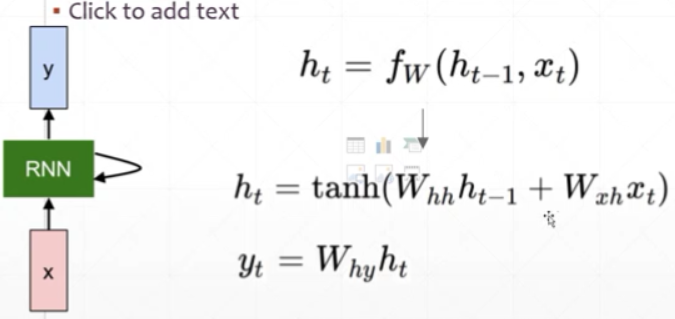
image.png

image.png

image.png